https://docs.pybamm.org/en/latest/source/examples/notebooks/models/SEI-on-cracks.html

In [ ]:
import pybamm as pb

In [22]:
# parameters:
parameter_values = pb.ParameterValues("OKane2022")

# swelling only model
no_cracks = pb.lithium_ion.DFN(
    options={
        "particle mechanics": "swelling only",
        "SEI": "solvent-diffusion limited",
        "SEI porosity change": "true",
        #"lithium plating": "reversible",
    }
)

# sei on cracks model
with_cracks = pb.lithium_ion.DFN(
    options={
        "SEI": "solvent-diffusion limited", 
        "SEI porosity change": "true",
        #"lithium plating": "reversible",
        "particle mechanics": "swelling and cracking",
        "SEI on cracks": "true",
    }
)

In [15]:
# setting the mesh size
var_pts = {
    "x_n": 20,  # negative electrode
    "x_s": 20,  # separator
    "x_p": 20,  # positive electrode
    "r_n": 26,  # negative particle
    "r_p": 26,  # positive particle
}

In [16]:
# solving the no crack model
exp = pb.Experiment(
    [
        "Hold at 4.2 V until C/100",
        "Rest for 1 hour",
        "Discharge at 1C until 2.5V",
    ]
)

In [17]:
sim1 = pb.Simulation(
    no_cracks,
    parameter_values=parameter_values,
    experiment=exp,
    var_pts=var_pts,
)
sol1 = sim1.solve(calc_esoh=False)

sim2 = pb.Simulation(
    with_cracks,
    parameter_values=parameter_values,
    experiment=exp,
    var_pts=var_pts,
)
sol2 = sim2.solve(calc_esoh=False)

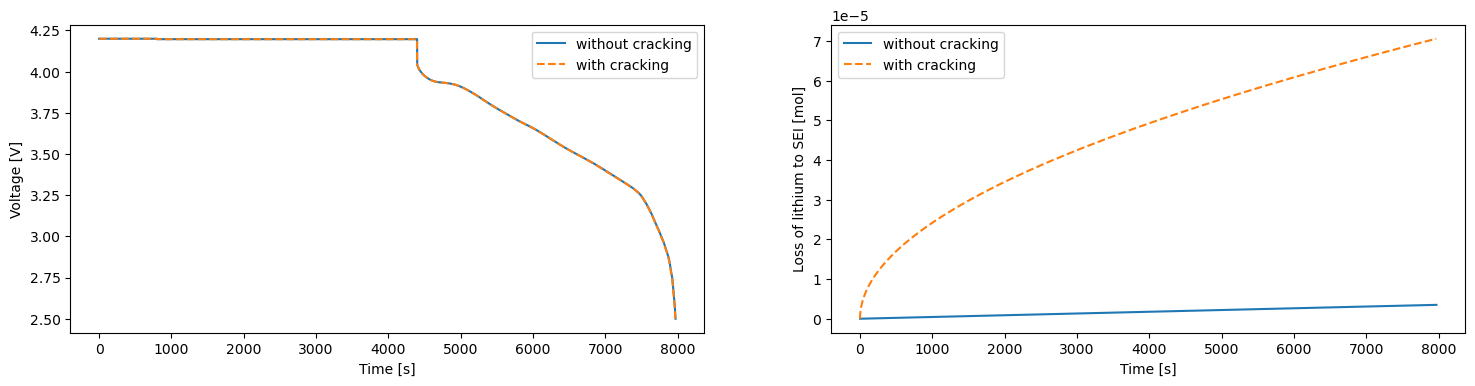

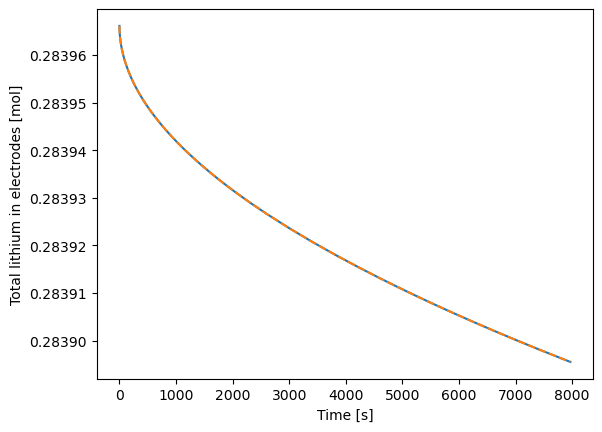

In [20]:
# extract the time, voltage, loss of lithium to SEI from the solutions
t1 = sol1["Time [s]"].entries
V1 = sol1["Voltage [V]"].entries
SEI1 = sol1["Loss of lithium to negative SEI [mol]"].entries
lithium_neg1 = sol1["Total lithium in negative electrode [mol]"].entries
lithium_pos1 = sol1["Total lithium in positive electrode [mol]"].entries

t2 = sol2["Time [s]"].entries
V2 = sol2["Voltage [V]"].entries
SEI2 = (
    sol2["Loss of lithium to negative SEI [mol]"].entries
    + sol2["Loss of lithium to negative SEI on cracks [mol]"].entries
)
lithium_neg2 = sol2["Total lithium in negative electrode [mol]"].entries
lithium_pos2 = sol2["Total lithium in positive electrode [mol]"].entries

# plot the voltage and loss of lithium to SEI against time
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 4))
ax1.plot(t1, V1, label="without cracking")
ax1.plot(t2, V2, label="with cracking", linestyle="dashed")
ax1.set_xlabel("Time [s]")
ax1.set_ylabel("Voltage [V]")
ax1.legend()
ax2.plot(t1, SEI1, label="without cracking")
ax2.plot(t2, SEI2, label="with cracking", linestyle="dashed")
ax2.set_xlabel("Time [s]")
ax2.set_ylabel("Loss of lithium to SEI [mol]")
ax2.legend()
plt.show()

# check lithium is conserved
fig, ax = plt.subplots()
ax.plot(t2, lithium_neg2 + lithium_pos2)
ax.plot(t2, lithium_neg2[0] + lithium_pos2[0] - SEI2, linestyle="dashed")
ax.set_xlabel("Time [s]")
ax.set_ylabel("Total lithium in electrodes [mol]")
plt.show()

In [23]:
model = pb.lithium_ion.DFN()
for name, submodel in model.submodels.items():
    print(name, submodel)

external circuit <pybamm.models.submodels.external_circuit.explicit_control_external_circuit.ExplicitCurrentControl object at 0x000002F067542030>
discharge and throughput variables <pybamm.models.submodels.external_circuit.discharge_throughput.DischargeThroughput object at 0x000002F0675420C0>
porosity <pybamm.models.submodels.porosity.constant_porosity.Constant object at 0x000002F05BED1A90>
Negative interface utilisation <pybamm.models.submodels.interface.interface_utilisation.full_utilisation.Full object at 0x000002F05BF599D0>
Positive interface utilisation <pybamm.models.submodels.interface.interface_utilisation.full_utilisation.Full object at 0x000002F0670F1850>
negative primaryparticle mechanics <pybamm.models.submodels.particle_mechanics.no_mechanics.NoMechanics object at 0x000002F0670F1B50>
positive primaryparticle mechanics <pybamm.models.submodels.particle_mechanics.no_mechanics.NoMechanics object at 0x000002F0670F1F10>
negative primary active material <pybamm.models.submodels.